In [1]:
import numpy as np
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
from design import Design
from film import FilmSimple
from spectrum import Spectrum
import pickle

def make_reflection_design(init_film: FilmSimple):
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500) # when wls = 50, ~100 min
    target_spec = [Spectrum(inc_ang, wls, np.ones(wls.shape[0], dtype='float'))]
    
    design = Design(target_spec, init_film)
    return design


ModuleNotFoundError: No module named 'grad_helper'

In [ ]:
# deisgn starting with SiO2
for run_num, init_ot in enumerate(np.linspace(1, 5000, 200)):
    if run_num < 149:
        continue
    d_init = np.array([init_ot], dtype='float')
    film = FilmSimple('SiO2', 'TiO2', 'SiO2', d_init)
    design = make_reflection_design(film)

    design.TFNN_train(max(50, run_num), record=True)

    fname = f'./raw_result/single_inc/reflection-0_inc-400to1000wls-init_single_layer_SiO2/{run_num}_design.pkl'
    with open(fname, 'wb') as f:
        pickle.dump(design, f)

In [6]:
# deisgn starting with SiO2, randomly initialized
for run_num, init_gt in enumerate(np.linspace(1, 5000, 200)):
    if run_num < 111:
        continue
    init_layer_number = 10
    np.random.seed(1)
    d_init = np.random.random(init_layer_number)
    d_init *= init_gt / d_init.sum()
    film = FilmSimple('SiO2', 'TiO2', 'SiO2', d_init)
    design = make_reflection_design(film)
    design.TFNN_train(needle_epoch=max(50, run_num), record=True, show=False, show_warning=False)
    fname = f'./raw_result/single_inc/reflection-0_inc-400to1000wls-init_{init_layer_number}_layer_SiO2/{run_num}_design.pkl'
    try: # may exceed layer number limit
        with open(fname, 'wb') as f:
            pickle.dump(design, f)
    except Exception as e:
        print(e)

KeyboardInterrupt: 

In [ ]:
# deisgn starting with TiO2
for run_num, init_ot in enumerate(np.linspace(1, 5000, 200)):

    d_init = np.array([init_ot], dtype='float')
    film = FilmSimple('TiO2', 'SiO2', 'SiO2', d_init)
    design = make_reflection_design(film)

    design.TFNN_train(max(50, run_num), record=True)

    fname = f'./raw_result/single_inc/reflection-0_inc-400to1000wls-init_single_layer_TiO2/{run_num}_design.pkl'
    with open(fname, 'wb') as f:
        pickle.dump(design, f)


In [98]:
import matplotlib.pyplot as plt
design_ls: list[Design] = []

for run_num in range(400):
    fname = f'./raw_result/single_inc/reflection-0_inc-400to1000wls-init_single_layer_SiO2/{run_num}_design.pkl'

    try:
        f = open(fname, 'rb')
        design_ls.append(pickle.load(f))
        f.close()
    except Exception as e:
        if e.args[0] != 2:  
            print(e.args)
        continue





' See cell below for the convergence in one gd optimization after needle. \nClearly inefficiency in escaping saddle point '

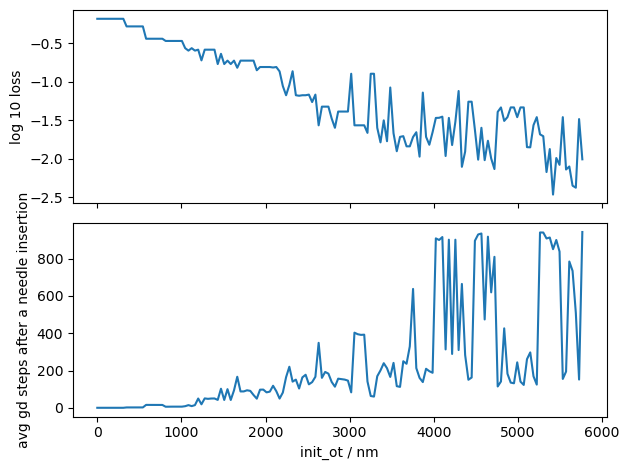

In [104]:
init_ot, loss = [], []
for d in design_ls:
    init_ot.append(d.get_init_ot())
    loss.append(d.calculate_loss())

fig, (ax1, ax2) = plt.subplots(2, 1, layout='tight', sharex=True)
ax1.plot(init_ot, np.log10(loss))
ax1.set_ylabel('log 10 loss')

avg_steps = []
init_ots = []
for desgin in design_ls:
    avg_steps.append(np.average([info['step'] for info in desgin.training_info]))
    init_ots.append(desgin.get_init_ot())

ax2.plot(init_ots, avg_steps)
ax2.set_ylabel('avg gd steps after a needle insertion') 
ax2.set_xlabel('init_ot / nm')

''' See cell below for the convergence in one gd optimization after needle. 
Clearly inefficiency in escaping saddle point '''
# TODO: similar experiment for Adam



removed 2
loss eqot: 0.007744717162379358
loss optim: 0.0047574434038447615


(<AxesSubplot: title={'center': 'refractive index distribution at  701 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

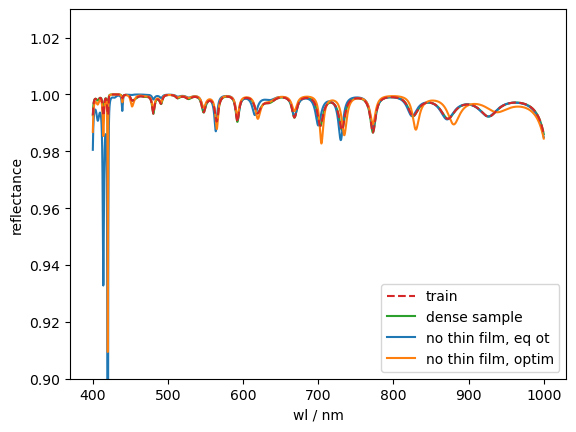

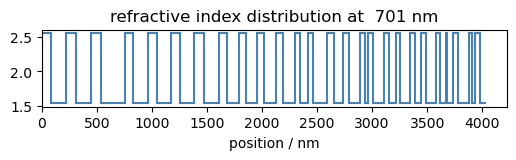

In [97]:
import copy
f_eqot = copy.deepcopy(f)
f_optim = copy.deepcopy(f)
from utils.substitutue import equal_optical_thickness, optimal_and_thin_film_approx_substitution_onestep_new
from utils.loss import calculate_RMS_f_spec
from analyze_utils.structure import plot_layer_thickness


idx = 146
fig, ax = plt.subplots(1, 1)
f = design_ls[idx].film
wls_target = np.linspace(400, 1000, 500)

d_min = 10.
equal_optical_thickness(f_eqot, d_min)
optimal_and_thin_film_approx_substitution_onestep_new(f_optim, d_min)
print(f'removed {f.get_layer_number() - f_eqot.get_layer_number()}')
print(f'loss eqot: {calculate_RMS_f_spec(f_eqot, design_ls[idx].target_specs)}')
print(f'loss optim: {calculate_RMS_f_spec(f_optim, design_ls[idx].target_specs)}')

ax.plot(f.get_spec(0., wls_target).WLS, f.get_spec(0., wls_target).get_R(), label='train', ls='--', zorder=100, c='C3')

wls_dense = np.linspace(400, 1000, 10000)
def plot_dense(f, label, c):
    ax.plot(wls_dense, f.get_spec(0., wls_dense).get_R(), label=label, zorder=0, c=c)
    f.remove_spec_param(wls=wls_dense)
plot_dense(f, 'dense sample', 'C2')
plot_dense(f_eqot, 'no thin film, eq ot', 'C0')
plot_dense(f_optim, 'no thin film, optim', 'C1')

ax.set_ylim(0.9, 1.03)
ax.set_xlabel('wl / nm')
ax.set_ylabel('reflectance')
# ax.set_xlim(400, 500)
ax.legend()

plot_layer_thickness(design_ls[idx].film)



100


Text(0, 0.5, 'loss')

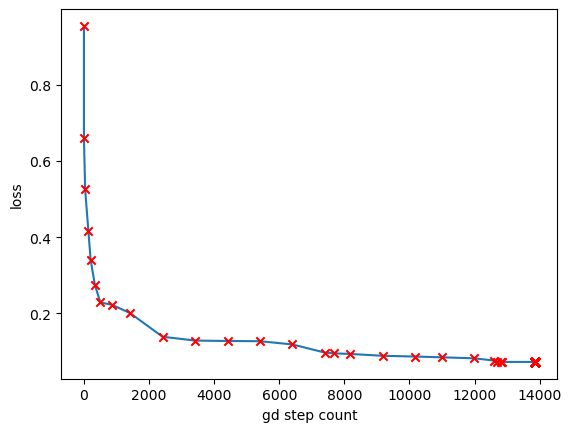

In [19]:
losses = []
epoch = []
design_idx = 100
for info in design_ls[design_idx].training_info:
    losses.append(info['loss'])
    epoch.append(info['step'])
print(len(epoch))
fig, ax = plt.subplots(1, 1)
ax.plot([sum(epoch[:i]) for i in range(len(epoch))], losses, label=f'design {design_idx}')
ax.scatter([sum(epoch[:i]) for i in range(len(epoch))], losses, label='needle insertion', marker='x', c='red', zorder=2)
ax.set_xlabel('gd step count')
ax.set_ylabel('loss')